#### Problem Statement: Customer Churn Prediction With PySpark

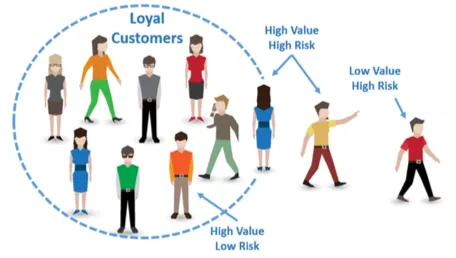

to draw a prediction about the potential customers who might stop buying their product / marketing services

The following command adds the pyspark to sys.path at runtime. If the pyspark is not on the system path by default. It also prints the path of the spark.

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

Create a Spark Session

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Hyperparameter") \
    .master('local[3]') \
    .getOrCreate()

23/01/21 08:05:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Read the dataset into a dataframe.

In [4]:
customer_churn = spark.read.csv('customer_churn.csv', inferSchema=True, header=True, mode='DROPMALFORMED')

<hr />
# Data Fields Explained
KEY FIELDS: <br>
1. customerID: Customer ID <br>
2. gender: Whether the customer is a male or a female<br>
3. SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)<br>
4. Partner: Whether the customer has a partner or not (Yes, No)<br>
5. Dependents: Whether the customer has dependents or not (Yes, No)<br>
6. tenure: Number of months the customer has stayed with the company<br>
7.mPhoneService: Whether the customer has a phone service or not (Yes, No)<br>
8. MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)<br>
9. InternetService: Customer’s internet service provider (DSL, Fiber optic, No)<br>
10. OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)<br>
11. OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)<br>
12. DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)<br>
13. TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)<br>
14. StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)<br>
15. StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)<br>
16. Contract: The contract term of the customer (Month-to-month, One year, Two year)<br>
17. PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)<br>
18. PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
19. MonthlyCharges: The amount charged to the customer monthly<br>
20. TotalCharges: The total amount charged to the customer<br>

PREDICTOR FIELD:<br>
1. Churn: Whether the customer churned or not (Yes or No)<br>
<hr />

In [5]:
customer_churn.show(1, truncate=False ,vertical=True)

-RECORD 0----------------------------
 customerID       | 7590-VHVEG       
 gender           | Female           
 SeniorCitizen    | 0                
 Partner          | Yes              
 Dependents       | No               
 tenure           | 1                
 PhoneService     | No               
 MultipleLines    | No phone service 
 InternetService  | DSL              
 OnlineSecurity   | No               
 OnlineBackup     | Yes              
 DeviceProtection | No               
 TechSupport      | No               
 StreamingTV      | No               
 StreamingMovies  | No               
 Contract         | Month-to-month   
 PaperlessBilling | Yes              
 PaymentMethod    | Electronic check 
 MonthlyCharges   | 29.85            
 TotalCharges     | 29.85            
 Churn            | No               
only showing top 1 row



Display the data type of the coulmns.

In [6]:
display(customer_churn.summary())

DataFrame[summary: string, customerID: string, gender: string, SeniorCitizen: string, Partner: string, Dependents: string, tenure: string, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: string, TotalCharges: string, Churn: string]

Dropping rows with NaN values

In [7]:
print("rows: {}".format(customer_churn.count()))
customer_churn = customer_churn.dropna()
print("rows after dropna",format(customer_churn.count()))

rows: 7043
rows after dropna 7043


Import the pyspark modules required for pre-processing the data.

In [8]:
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml import Pipeline,Model
from pyspark.ml.tuning import ParamGridBuilder

stringIndexer_1= StringIndexer(inputCol="gender", outputCol="gender_IX")
stringIndexer_2 = StringIndexer(inputCol="Partner", outputCol="Partner_IX")
stringIndexer_3 = StringIndexer(inputCol="Dependents", outputCol="Dependents_IX")
stringIndexer_4 = StringIndexer(inputCol="PhoneService", outputCol="PhoneService_IX")
stringIndexer_5 = StringIndexer(inputCol="MultipleLines", outputCol="MultipleLines_IX")
stringIndexer_6 = StringIndexer(inputCol="InternetService", outputCol="InternetService_IX")
stringIndexer_7 = StringIndexer(inputCol="OnlineSecurity", outputCol="OnlineSecurity_IX")
stringIndexer_8 = StringIndexer(inputCol="OnlineBackup", outputCol="OnlineBackup_IX")
stringIndexer_9 = StringIndexer(inputCol="DeviceProtection", outputCol="DeviceProtection_IX")
stringIndexer_10 = StringIndexer(inputCol="TechSupport", outputCol="TechSupport_IX")
stringIndexer_11= StringIndexer(inputCol="StreamingTV", outputCol="StreamingTV_IX")
stringIndexer_12= StringIndexer(inputCol="StreamingMovies", outputCol="StreamingMovies_IX")
stringIndexer_13= StringIndexer(inputCol="Contract", outputCol="Contract_IX")
stringIndexer_14= StringIndexer(inputCol="PaperlessBilling", outputCol="PaperlessBilling_IX")
stringIndexer_15= StringIndexer(inputCol="PaymentMethod", outputCol="PaymentMethod_IX")

vectorAssembler_features = VectorAssembler(inputCols=["gender_IX", "Partner_IX","Dependents_IX","PhoneService_IX","MultipleLines_IX","InternetService_IX","OnlineSecurity_IX","OnlineBackup_IX","DeviceProtection_IX","TechSupport_IX","StreamingTV_IX","StreamingMovies_IX","Contract_IX","PaperlessBilling_IX","PaymentMethod_IX","MonthlyCharges","tenure"],outputCol="features")
stringIndexer_label = StringIndexer(inputCol="Churn", outputCol="label").fit(customer_churn)

In [9]:
customer_churn = customer_churn.withColumn("TotalCharges",customer_churn.TotalCharges.cast('float'))

Create the pre-processing pipeline

In [10]:
pipeline = Pipeline(stages=[])

basePipeline = [stringIndexer_1, stringIndexer_2,stringIndexer_3, stringIndexer_4,stringIndexer_5, stringIndexer_6,stringIndexer_7, stringIndexer_8,stringIndexer_9, stringIndexer_10,stringIndexer_11, stringIndexer_12,stringIndexer_13, stringIndexer_14,stringIndexer_15,stringIndexer_label, vectorAssembler_features]

Define the Models for trying during the hyperparameter tuning and the associated hyperparameter values

In [11]:
lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10)
pl_lr = basePipeline + [lr]
pg_lr = ParamGridBuilder()\
          .baseOn({pipeline.stages: pl_lr})\
          .addGrid(lr.regParam,[0.01, .04])\
          .addGrid(lr.elasticNetParam,[0.1, 0.4])\
          .build()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pl_rf = basePipeline + [rf]
pg_rf = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_rf})\
      .addGrid(rf.numTrees, [10, 25, 50])\
      .build()


paramGrid = pg_lr + pg_rf 

Split the data into training and testing sets.

In [12]:
splitted_data = customer_churn.randomSplit([0.6, 0.4], 24)   
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 4226
Number of testing records : 2817


Build a Crossvalidator for hyperparameter tuning

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit
cv = TrainValidationSplit(trainRatio=0.8)\
      .setEstimator(pipeline)\
      .setEvaluator(BinaryClassificationEvaluator())\
      .setEstimatorParamMaps(paramGrid)

cvmodel = cv.fit(train_data)

23/01/21 08:06:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/01/21 08:06:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Display the stages of the pipeline.

In [14]:
cvmodel.bestModel.stages

[StringIndexerModel: uid=StringIndexer_fc883786ea5b, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_42f66d7d6cea, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_93a33c3d2d14, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_1745d8857d1d, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_234d7043ce9a, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_c232665ac395, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_9b05dfcde6fe, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_ba0045ec6ffd, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_2d6857054193, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_29c3605ae3b5, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_9128f23ca3ce, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_7fdb6f3402ed, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_ede1cce0bcdf, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer

Get the best model determined from the hyperparameter tuning

In [15]:
model = cvmodel.bestModel

Generate the predictions for the test data.

In [16]:
predictions = model.transform(test_data)

Determine the count of correct and incorrect predictions

In [17]:
correct = predictions.where("(label = prediction)").count()
incorrect = predictions.where("(label != prediction)").count()

print("Number of Correct predictions are ", correct)
print("Number of In-Correct predictions are ", incorrect)

23/01/21 08:06:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of Correct predictions are  2219
Number of In-Correct predictions are  598


Display the actual label and the prediction columns

In [18]:
predictions.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



Determine the values of the confusion matrix.

In [19]:
tp = predictions.filter("label == 1.0 AND prediction == 1.0").count()
tn = predictions.where("label == 0.0 AND prediction == 0.0").count()
fp = predictions.where("label == 0.0 AND prediction == 1.0").count()
fn = predictions.where("label == 1.0 AND prediction == 0.0").count()

print("True Positive", tp)
print("True Negative", tn)
print("False Positive", fp)
print("False Negative", fn)

True Positive 308
True Negative 1911
False Positive 159
False Negative 439


Determine the Precision and Recall Values.

In [20]:
r = float(tp)/(tp + fn)
print("recall", r)

p = float(tp) / (tp + fp)
print("precision", p)

recall 0.41231593038821956
precision 0.6595289079229122


Stop the Spark Session

In [21]:
spark.stop()